In [1]:
import cedalion
import cedalion.io
import cedalion.nirs
import cedalion.models.glm as glm
import numpy as np
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
from cedalion import units
xr.set_options(display_expand_data=False)

# Define Parameters

In [2]:
# remove first 20 seconds of data (motion artefacts)
omsec = 20

# subject list
subjects = [86, 91, 92, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104]
subjects = [91]

In [3]:
DATADIR = Path("/home/eike/Projekte/ibslab/30_dev/thomas_fa/Data/RESTING_DATA")

# Load Data

In [4]:
# store data of different subjects in a dictionary
data = {}
#for subject in subjects:
for sbj in subjects:

    recordings = cedalion.io.read_snirf(
        DATADIR.joinpath(f"Subj{sbj}/resting_sim_100_shorterHRF.snirf")
    )
    rec = recordings[0]

    # work around missing units in snirf file
    rec["amp"] = rec["amp"].pint.dequantify().pint.quantify("volts")
    rec["amp"] = rec["amp"].pint.quantify({"time" : "s"})

    rec.stim.cd.rename_events( {
        "1" : "Stim",
        "2" : "Rest",
    })

    ## remove unused stims
    #rec.stim = rec.stim.loc[rec.stim.onset>=omsec]
    ## if first trial is of cond rest, then remove this trial
    #if rec.stim.onset.min() == rec.stim.onset[rec.stim.trial_type == "Rest"].min():
    #    rec.stim = rec.stim.loc[rec.stim.onset > rec.stim.onset.min()]

    ## if last trial is of cond stim, then remove this trial
    #if rec.stim.onset.max() == rec.stim.onset[rec.stim.trial_type == "Stim"].max():
    #    rec.stim = rec.stim.loc[rec.stim.onset < rec.stim.onset.max()]

    dpf = xr.DataArray(
        [6, 6],
        dims="wavelength",
        coords={"wavelength" : rec["amp"].wavelength}
    )

    #rec["amp"] = rec["amp"].sel(time = rec["amp"].time >= omsec)

    rec["od"] = - np.log( np.abs(rec["amp"] / rec["amp"].mean("time")) )

    rec["od_filtered"] = rec["od"].cd.freq_filter(0, 0.5, 6)

    rec["conc"] = cedalion.nirs.od2conc(rec["od"], rec.geo3d, dpf, "prahl")
    rec["conc_filtered"] = cedalion.nirs.od2conc(rec["od_filtered"], rec.geo3d, dpf, "prahl")

    data[sbj] = rec

# Select Example Subject

In [5]:
sbj = 91
rec = data[sbj]

In [6]:
display(rec)

<Recording |  timeseries: ['amp', 'od', 'od_filtered', 'conc', 'conc_filtered'],  masks: [],  stim: ['Stim', 'Rest'],  aux_ts: ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8'],  aux_obj: []>

In [7]:
rec.stim.sort_values("onset")

,onset,duration,value,trial_type
0,0.80,10.0,1.0,Stim
18,20.64,10.0,1.0,Rest
1,36.92,10.0,1.0,Stim
19,55.80,10.0,1.0,Rest
2,74.48,10.0,1.0,Stim
20,93.12,10.0,1.0,Rest
3,111.36,10.0,1.0,Stim
21,127.92,10.0,1.0,Rest
4,144.52,10.0,1.0,Stim
22,162.56,10.0,1.0,Rest


# Build design matrix

In [8]:
ts_long, ts_short = cedalion.nirs.split_long_short_channels(
    rec["conc_filtered"], rec.geo3d, distance_threshold=1.5 * units.cm
)

dm, channel_wise_regressors = glm.make_design_matrix(
    ts_long,
    ts_short,
    rec.stim,
    rec.geo3d,
    # basis_function=glm.Gamma(tau=0 * units.s, sigma=5 * units.s, T=0 * units.s),
    basis_function=glm.GaussianKernels(
        t_pre=5 * units.s, t_post=15 * units.s, t_delta=2 * units.s, t_std=2 * units.s
    ),
    drift_order=1,
    short_channel_method="closest",
)

display(dm)
display(channel_wise_regressors)

<xarray.DataArray (time: 16050, regressor: 10, chromo: 2)> Size: 3MB
0.6169 0.6169 0.2398 0.2398 0.05653 0.05653 0.008083 ... 0.0 0.0 1.0 1.0 1.0 1.0
Coordinates:
  * time       (time) float64 128kB 0.0 0.04 0.08 0.12 ... 641.9 641.9 642.0
  * regressor  (regressor) <U10 400B 'HRF Stim 0' 'HRF Stim 1' ... 'Drift 1'
  * chromo     (chromo) <U3 24B 'HbO' 'HbR'

[<xarray.DataArray 'concentration' (regressor: 1, chromo: 2, channel: 48,
                                    time: 16050)> Size: 12MB
 [µM] 0.4035 0.3415 0.2796 0.2178 0.1565 ... -3.701 -3.809 -3.904 -3.988 -4.06
 Coordinates:
   * chromo         (chromo) <U3 24B 'HbO' 'HbR'
   * time           (time) float64 128kB 0.0 0.04 0.08 0.12 ... 641.9 641.9 642.0
     samples        (time) int64 128kB 0 1 2 3 4 ... 16046 16047 16048 16049
   * channel        (channel) object 384B 'S1D1' 'S1D7' ... 'S16D28' 'S16D32'
     short_channel  (channel) object 384B 'S2D5' 'S2D5' ... 'S16D30' 'S16D30'
     comp_group     (channel) int64 384B 0 0 0 0 0 0 0 1 0 ... 5 6 6 6 7 6 7 7 7
   * regressor      (regressor) <U5 20B 'short']

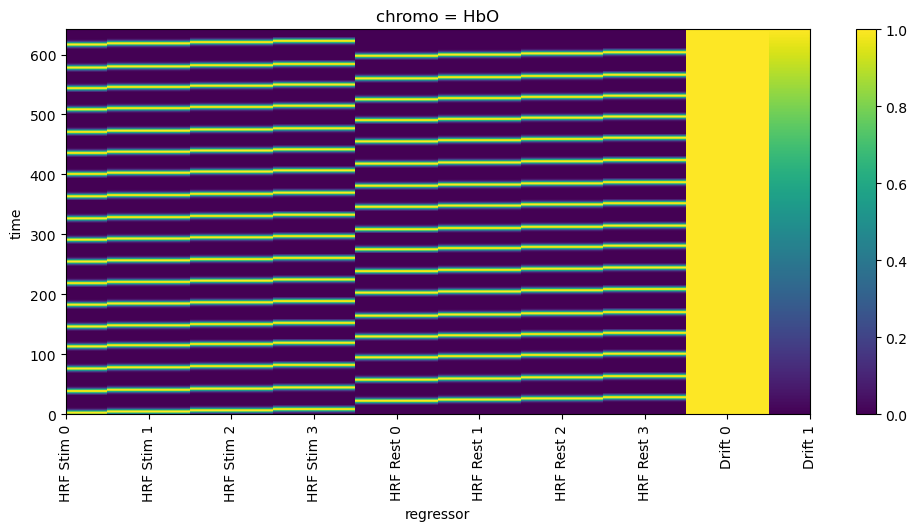

(0.0, 60.0)

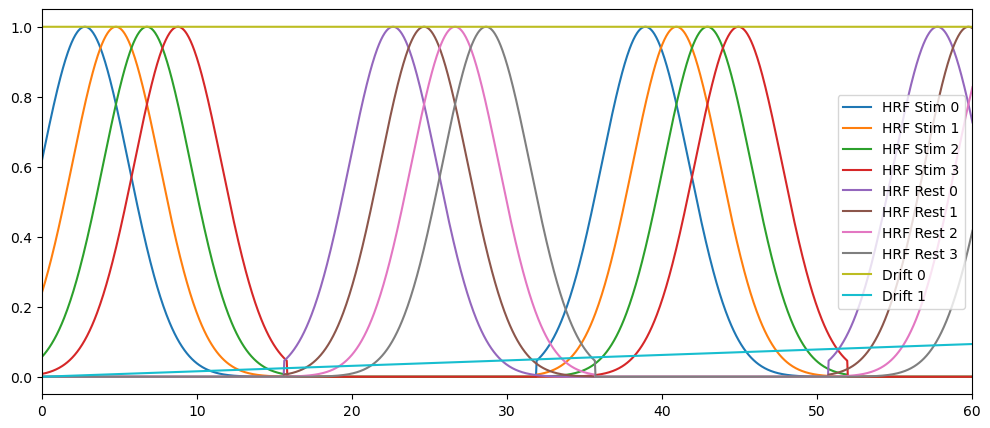

In [9]:
f, ax = plt.subplots(1,1,figsize=(12,5))
dm.sel(chromo="HbO").plot()
plt.xticks(rotation=90)
plt.show()

f, ax = plt.subplots(1,1,figsize=(12,5))
for reg in dm.regressor.values:
    plt.plot(dm.time, dm.sel(chromo="HbO", regressor=reg), label=reg)
plt.legend()
plt.xlim(0,60)

In [10]:
thetas = glm.fit(ts_long, dm, channel_wise_regressors)
display(thetas)

<xarray.DataArray (regressor: 11, channel: 48, chromo: 2)> Size: 8kB
-0.1039 0.2479 0.2793 -0.05983 ... 0.006487 3.036e-05 0.009714 -0.0001852
Coordinates:
  * regressor  (regressor) <U10 440B 'HRF Stim 0' 'HRF Stim 1' ... 'short'
  * channel    (channel) object 384B 'S1D1' 'S1D7' 'S2D1' ... 'S16D28' 'S16D32'
  * chromo     (chromo) <U3 24B 'HbO' 'HbR'

<xarray.DataArray (time: 16050, channel: 48, chromo: 2)> Size: 12MB
-0.8861 -0.8501 -0.1872 -0.6248 -0.1875 ... -0.4453 -0.01594 0.2168 0.1521
Coordinates:
  * time           (time) float64 128kB 0.0 0.04 0.08 0.12 ... 641.9 641.9 642.0
  * chromo         (chromo) <U3 24B 'HbO' 'HbR'
    samples        (time) int64 128kB 0 1 2 3 4 ... 16046 16047 16048 16049
  * channel        (channel) object 384B 'S1D1' 'S1D7' ... 'S16D28' 'S16D32'
    short_channel  (channel) object 384B 'S2D5' 'S2D5' ... 'S16D30' 'S16D30'
    comp_group     (channel) int64 384B 0 0 0 0 0 0 0 0 1 ... 5 6 6 6 6 7 7 7 7

<xarray.DataArray (time: 16050, channel: 48, chromo: 2)> Size: 12MB
0.1078 0.07066 0.1939 -0.05996 0.004461 0.005295 ... 0.0 0.0 0.0 0.0 0.0 0.0
Coordinates:
  * time           (time) float64 128kB 0.0 0.04 0.08 0.12 ... 641.9 641.9 642.0
  * chromo         (chromo) <U3 24B 'HbO' 'HbR'
    samples        (time) int64 128kB 0 1 2 3 4 ... 16046 16047 16048 16049
  * channel        (channel) object 384B 'S1D1' 'S1D7' ... 'S16D28' 'S16D32'
    short_channel  (channel) object 384B 'S2D5' 'S2D5' ... 'S16D30' 'S16D30'
    comp_group     (channel) int64 384B 0 0 0 0 0 0 0 0 1 ... 5 6 6 6 6 7 7 7 7

(0.0, 100.0)

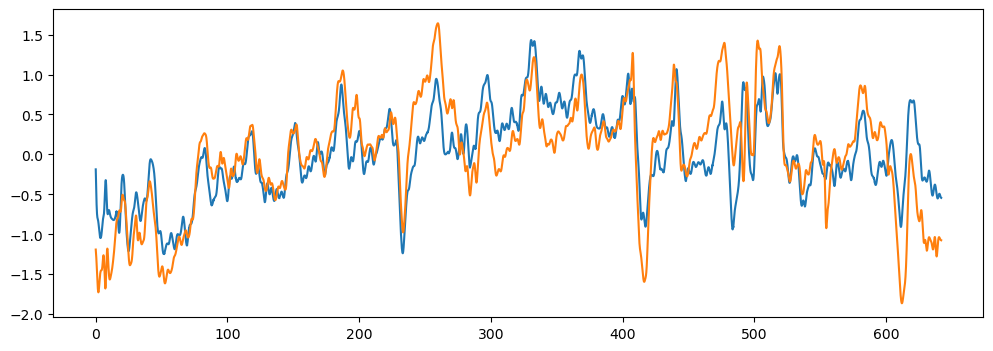

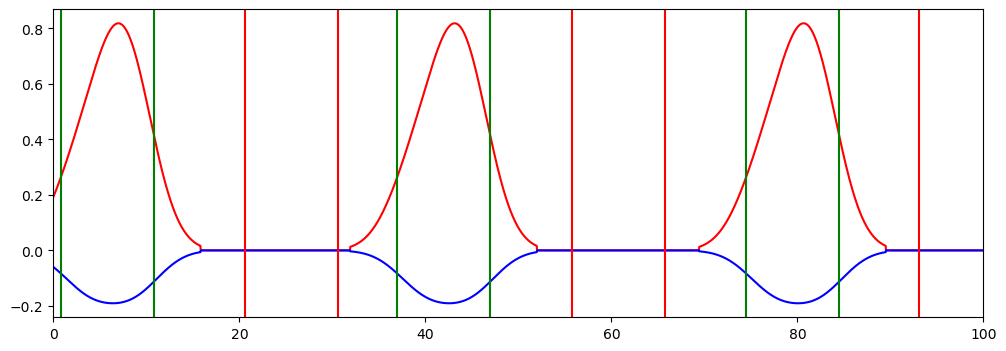

In [11]:
pred = glm.predict(ts_long, thetas, dm, channel_wise_regressors)

display(pred)
plt.figure(figsize=(12, 4))
plt.plot(pred.time, pred.sel(chromo="HbO", channel="S1D7"))
plt.plot(ts_long.time, ts_long.sel(chromo="HbO", channel="S1D7"))


pred = glm.predict(
    ts_long,
    thetas.sel(regressor=thetas.regressor.str.startswith("HRF Stim")),
    dm,
    channel_wise_regressors,
)
display(pred)
plt.figure(figsize=(12, 4))
plt.plot(pred.time, pred.sel(chromo="HbO", channel="S1D7"), "r-")
plt.plot(pred.time, pred.sel(chromo="HbR", channel="S1D7"), "b-")

for _, r in rec.stim.iterrows():
    if r.trial_type == "Stim":
        plt.axvline(r.onset, c="g")
        plt.axvline(r.onset + r.duration, c="g")
    elif r.trial_type == "Rest":
        plt.axvline(r.onset, c="r")
        plt.axvline(r.onset + r.duration, c="r")

plt.xlim(0,100)

/tmp/ipykernel_17016/111549289.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for i in rec.stim.sort_values("onset")[rec.stim.trial_type=="Stim"].head(6)["onset"].values:


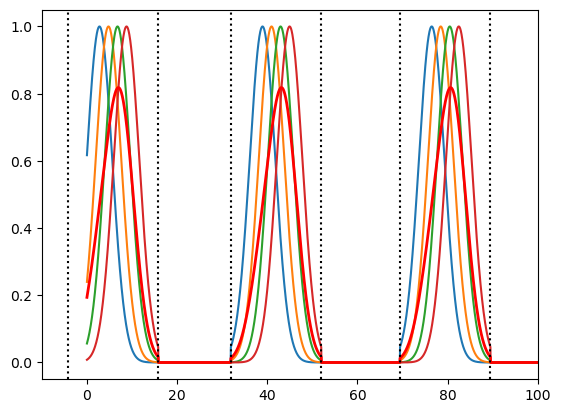

In [15]:
xx = dm.sel(chromo="HbO", regressor=dm.regressor.str.startswith("HRF Stim"))
for i in range(4):
    plt.plot(xx.time, xx[:, i])

plt.plot(pred.time, pred.sel(chromo="HbO", channel="S1D7"), "r-", lw=2)

plt.xlim(-10,100)
for i in rec.stim.sort_values("onset")[rec.stim.trial_type=="Stim"].head(6)["onset"].values:
    plt.axvline(i-5, c="k", ls=":")
    plt.axvline(i+15, c="k", ls=":")

### Short channels

In [13]:
# Random regressor
#rand = np.ones((len(conc.time), len(conc.chromo), 1))
#rand = xr.DataArray(
#            rand,
#            dims=["time", "chromo", "regressor"],
#            coords={
#                "time" : conc.time,
#                "chromo" : conc.chromo,
#                "regressor" : ["rand"]
#            }
#).pint.quantify(conc.pint.units)

# Append regressor array to local regressor dictionary
#local_regs['data'] = xr.concat([local_regs['data'], rand], dim="regressor")

# Select channels to which the random regressor is assigned
#local_regs['HbO']['rand'] = ["S1D7", "S3D3", "S4D9"]
#local_regs['HbR']['rand'] = ["S7D11", "S3D3"]

# Solve GLM

In [14]:
# solve GLM
thetas, predicted, predicted_hrf = cd_glm.solve_glm(
    conc,
    dm_cd,
    local_regs,
    noise_model='ols'
)
print(thetas.sel(channel="S1D7", chromo="HbO"))

NameError: name 'cd_glm' is not defined

In [ ]:
# plot predicted data
predicted.sel(chromo="HbO", channel="S1D7").plot()
predicted_hrf.sel(chromo="HbO", channel="S1D7").plot()
# plot true data
data[sbj].data_vars["conc"].sel(chromo="HbO", channel="S1D7").plot()
# add legend
plt.legend(["predicted", "predicted_hrf", "true"])
plt.show()

In [ ]:
# extract HRFs for each channel, chromophore and condition
hrfs = cd_glm.get_HRFs(predicted_hrf, stim, HRFmin=HRF_tmin, HRFmax=HRF_tmax)

In [ ]:
hrfs.sel(chromo="HbO", channel="S1D7", condition='Stim').plot()
hrfs.sel(chromo="HbO", channel="S1D7", condition='Rest').plot()
plt.legend(["Stim", "Rest"])
plt.show()